In [1]:
from sklearn import metrics
import joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from numpy.random import seed
seed(42)
import tensorflow as tf

In [4]:
import pytz
from datetime import timedelta, datetime
local_tz = pytz.timezone('America/Toronto') # Set local timezone for InfluxDB based times calculations
today=datetime.today().strftime('%Y-%m-%d')

#### Note: if you did not create new data for the model training, a sample is provided in this repository. 
#### To use it, ensure that in the next cell the instruction with the file name lt_results_2022-10-01.csv in it is executed and not the one using "today's" date

In [5]:
#data = pd.read_csv('lt_results_'+today+'.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)
data = pd.read_csv('lt_results_2022-10-01.csv', index_col='DateTime', parse_dates=True, infer_datetime_format=True)

In [6]:
data.head()

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,req2xx,testDurationSeconds,timeoutSeconds
DateTime,,,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,50679.0,165.0,5.0
2022-09-28 15:34:42+00:00,True,30.0,173.0,2788.0,158.0,1.0,347.427221,35.0,146793.0,423.0,5.0
2022-09-28 15:47:10+00:00,True,28.0,125.0,1411.0,110.0,15.0,138.693699,14.0,84757.0,611.0,5.0
2022-09-28 15:56:35+00:00,True,14.0,115.0,1176.0,100.0,12.0,158.212165,16.0,68515.0,433.0,5.0
2022-09-28 16:01:09+00:00,True,30.0,226.0,2296.0,211.0,12.0,245.806605,25.0,34173.0,139.0,5.0


In [7]:
data = data.drop(columns=['req2xx', 'testDurationSeconds'])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data.mean_tps,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((74, 9), (9, 9))

In [9]:
target_var = 'mean_tps'
X_train = X_train.drop(target_var, axis=1)
X_test = X_test.drop(target_var, axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
stdScaler = StandardScaler()
targetStdScaler = StandardScaler()

In [13]:
X_train_scaled = stdScaler.fit_transform(X_train.values)
y_train_scaled = targetStdScaler.fit_transform(y_train.values.reshape(-1,1))

In [14]:
X_test_scaled = stdScaler.transform(X_test.values)
y_test_scaled = targetStdScaler.transform(y_test.values.reshape(-1,1))

In [15]:
# Neural Nets imports
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [16]:
verboseLevel=0
validationSplit=0.2
batchSize=30
epochs=1000

In [18]:
# callback preparation
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=verboseLevel,
                              mode='min',
                              min_lr=0.001)

In [19]:
inputSize = X_train_scaled.shape[1]
colList = ['HiddenLayers', 'R2Score', 'MAE', 'MSE', 'MAPE', 'H5FileName', 'TrainHistory', 'TrainPredictions']

In [20]:
target_loss = 'mae'
#loss = 'mse'
measure_metrics = ['mae', 'mse']
#measure_metrics = ['mae']

In [21]:
def createModel(testResultsFrame, layerSize, loops, target_loss, measure_metrics,
                y_train, X_train, y_test, X_test, targetScaler, labelSet):
    print(f'Creating model using layer size = {layerSize} on set = {labelSet}.\n')
    for i in range(loops):
        print(f'Training on {i} hidden layers\n')
        model = Sequential()
        model.add(Dense(layerSize, kernel_initializer='normal',
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        input_dim=inputSize, activation='relu'))
        for j in range(i):
            model.add(Dense(layerSize, 
                            #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                            #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                            #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                            kernel_initializer='normal', activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer='normal', 
                        #kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01),
                        #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                        #kernel_regularizer=l1_l2(0.01), bias_regularizer=l1_l2(0.01),
                        activation='linear'))

        optmzr=Adam(learning_rate=0.001)    
        model.compile(optimizer=optmzr, loss=target_loss, metrics=measure_metrics)

        model_h5_name = 'mlp_' + str(layerSize)+ '_' + str(i) + '_model_std_' + labelSet + '.h5'
        checkpoint_nn_std = ModelCheckpoint(model_h5_name,
                                 monitor='val_loss',
                                 verbose=verboseLevel,
                                 save_best_only=True,
                                 mode='min')
        callbacks_list_nn_std = [checkpoint_nn_std, reduce_lr]

        history_MLP_std = model.fit(X_train, y_train,
                                    batch_size=batchSize, 
                                    validation_split=validationSplit, 
                                    epochs=epochs, verbose=verboseLevel,
                                    callbacks=callbacks_list_nn_std)

        #reload the best model!
        model_new = load_model(model_h5_name)
        #Predict
        y_pred_scaled = model_new.predict(X_test)
        #Evaluate metrics
        y_pred = targetScaler.inverse_transform(y_pred_scaled)
        r2_score = metrics.r2_score(y_test, y_pred)
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
        #store values
        row = [i, r2_score, mae, mse, mape, model_h5_name, history_MLP_std, y_pred]
        df = pd.DataFrame(np.array(row, dtype=object).reshape(1, len(colList)), columns=colList)
        testResultsFrame = testResultsFrame.append(df, ignore_index=True)

        tf.keras.backend.clear_session()
        del(model)
        del(model_new)
        
    return testResultsFrame


In [22]:
%%time
testResDataFrame = pd.DataFrame(columns=colList)
layerSize = 64
loops = 15
testResDataFrame = createModel(testResDataFrame, layerSize, loops, 
                        target_loss, measure_metrics,
                        y_train_scaled, X_train_scaled,
                        y_test, X_test_scaled, 
                        targetStdScaler, 'all')


Creating model using layer size = 64 on set = all.

Training on 0 hidden layers

Training on 1 hidden layers

Training on 2 hidden layers

Training on 3 hidden layers

Training on 4 hidden layers

Training on 5 hidden layers

Training on 6 hidden layers

Training on 7 hidden layers

Training on 8 hidden layers

Training on 9 hidden layers

Training on 10 hidden layers

Training on 11 hidden layers

Training on 12 hidden layers

Training on 13 hidden layers

Training on 14 hidden layers

CPU times: user 7min 41s, sys: 1min 34s, total: 9min 15s
Wall time: 6min 30s


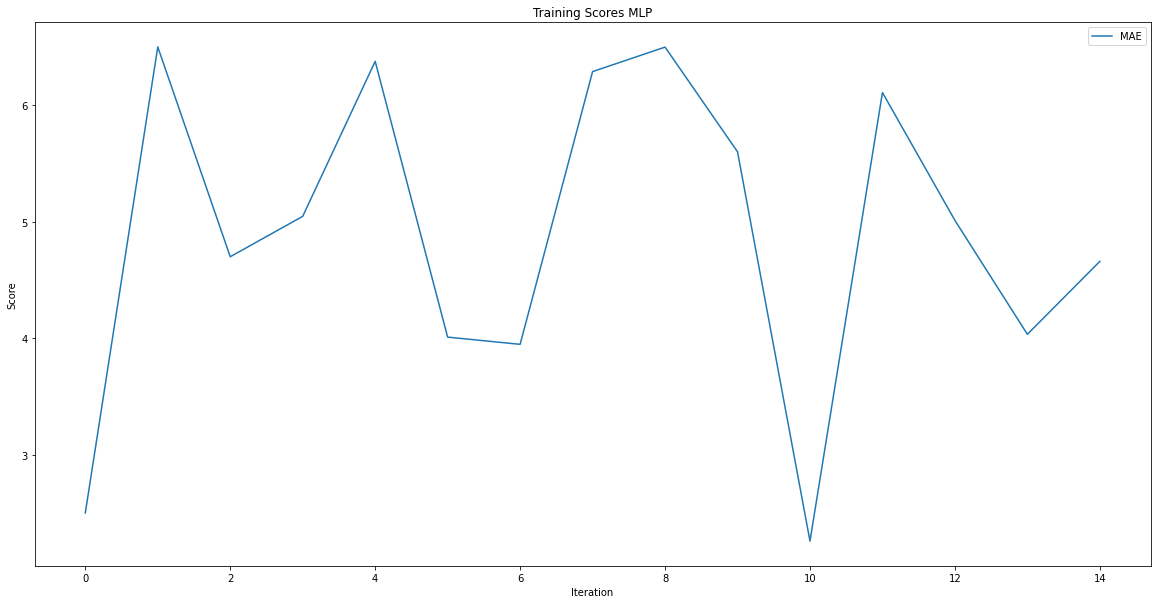

In [23]:
#Plot train vs validation
plt.figure(figsize=(20,10))
#plt.plot(testResDataFrame['R2Score'])
plt.plot(testResDataFrame['MAE'])
#plt.plot(testResDataFrame['MSE'])
plt.title('Training Scores MLP')
plt.ylabel('Score')
plt.xlabel('Iteration')
plt.legend(['MAE'], loc='upper right')
plt.show()

In [24]:
# Determine the IDX value where the MAE is smallest
minMaeIDX = testResDataFrame.loc[testResDataFrame['MAE']==testResDataFrame['MAE'].min()].index[0]

In [25]:
testResDataFrame.iloc[minMaeIDX]

HiddenLayers                                                       10
R2Score                                                      0.998107
MAE                                                          2.259626
MSE                                                         15.776504
MAPE                                                         0.016635
H5FileName                                 mlp_64_10_model_std_all.h5
TrainHistory        <keras.callbacks.History object at 0x7ff3e0146...
TrainPredictions    [[245.77635], [97.81441], [276.23853], [137.10...
Name: 10, dtype: object

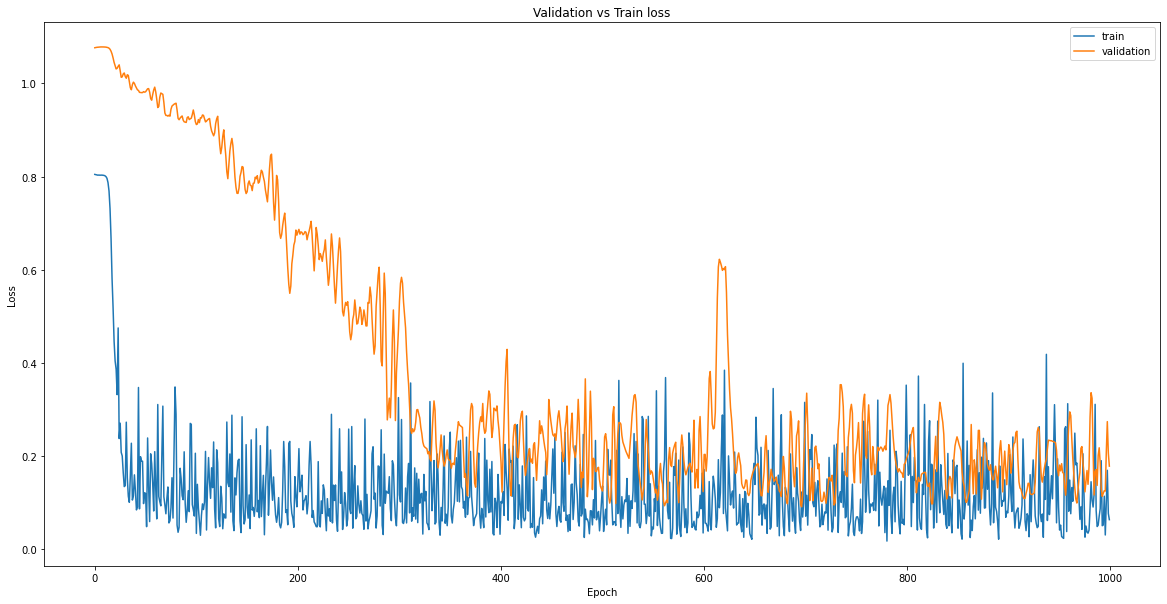

In [26]:
history_MLP = testResDataFrame['TrainHistory'][minMaeIDX]
#Plot train vs validation
plt.figure(figsize=(20,10))
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.title('Validation vs Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

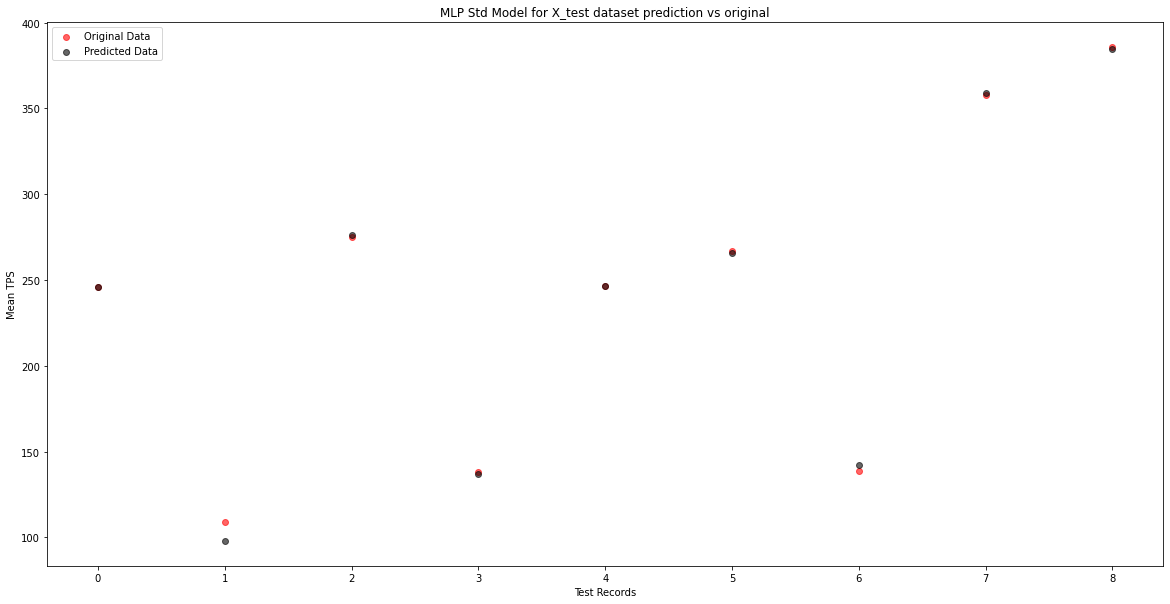

In [27]:
y_pred_MLP_std = testResDataFrame['TrainPredictions'][minMaeIDX]
# Plot prediction vs original
plt.figure(figsize=(20,10))
plt.scatter(range(y_test.shape[0]),y_test,label="Original Data", alpha=0.6, c='red')
plt.scatter(range(y_pred_MLP_std.shape[0]),y_pred_MLP_std,label="Predicted Data", 
            alpha=0.6, c='black')
plt.ylabel('Mean TPS')
plt.xlabel('Test Records')
plt.title('MLP Std Model for X_test dataset prediction vs original')
plt.legend()
plt.show()

In [28]:
X_test.columns

Index(['asyncResp', 'asyncRespThreads', 'cThreads', 'jacptQSize',
       'jacptThreads', 'ltTargetSize', 'numConnections', 'timeoutSeconds'],
      dtype='object')

In [29]:
data.head(1)

,asyncResp,asyncRespThreads,cThreads,jacptQSize,jacptThreads,ltTargetSize,mean_tps,numConnections,timeoutSeconds
DateTime,,,,,,,,,
2022-09-28 15:25:25+00:00,True,21.0,277.0,1712.0,262.0,7.0,307.015227,31.0,5.0


In [30]:
record = [[True, 21, 277, 1712, 262, 7, 31, 5]]

In [31]:
test_rec = stdScaler.transform(record)

In [32]:
test_rec

array([[ 0.34815531, -0.16614866,  1.14391569, -0.53671704,  1.14391569,
        -0.29012346,  0.90504761,  0.30039875]])

In [33]:
test_model = load_model(testResDataFrame['H5FileName'][minMaeIDX])

In [34]:
test_pred = test_model.predict(test_rec)

In [35]:
test_pred

array([[0.9162712]], dtype=float32)

In [36]:
targetStdScaler.inverse_transform(test_pred)

array([[307.7296]], dtype=float32)

### Save the scalers for the inference calls

In [37]:
joblib.dump(targetStdScaler,'target_scaler.pkl')

['target_scaler.pkl']

In [38]:
joblib.dump(stdScaler,'standard_scaler.pkl')

['standard_scaler.pkl']

### Export to ONNX to run on the RHODS model server

In [40]:
!pip3 install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 kB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 139.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 335.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.4 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

[notice] A new release of pip available: 22.3 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [41]:
import tf2onnx

In [42]:
model_onnx, _ = tf2onnx.convert.from_keras(test_model, output_path='tf_mlasp.onnx')

### Upload model to S3 bucket

In [54]:
aws_access_key_id = 'key'
aws_secret_access_key = 'key'
region_name = 'us-east-1'

endpoint_url = 'https://rados-gw-url'

In [56]:
#!pip3 install boto3==1.26.63
#!pip3 install botocore=1.29.63

In [51]:
import boto3
import botocore

In [57]:
#S3 AWS client
s3_aws = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = region_name)

In [ ]:
#S3 Rados GW client
s3_rados = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = 'default',
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [58]:
s3_aws.upload_file('tf_mlasp.onnx', 'mlasp', 'models/tf_mlasp.onnx')